In [1]:
import pandas as pd
import numpy as np
import gc

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc, precision_score, recall_score
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler
from tqdm import tqdm
SEED = 1996
FOLDS = 5
TARGET = "y"
VERSION = "lgbm-v5"

# Load Data

In [2]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
df_sub = pd.read_csv("../data/submission_sample.csv")
df_meta = pd.read_csv("../data/metadata.csv")

In [3]:
df_meta["Variavel tipo"].value_counts()

Qualitativo nominal      36
Quantitativo discreto    18
Quantitativo continua    12
Qualitativo ordinal       4
Name: Variavel tipo, dtype: int64

## Vars type

- **Variável qualitativa nominal** = valores que expressam atributos, sem
nenhum tipo de ordem. Ex: cor dos olhos, sexo, estado civil, presença ou
ausência...


- **Variável qualitativa ordinal** = valores que expressam atributos, porém com
algum tipo de ordem, ou grau. Ex: grau de escolaridade (1º grau, 2º grau, 3º
grau, pós-graduação...); resposta de um paciente (nenhuma melhora, alguma
melhora, muita melhora); classe social (alta, média, baixa)...


- **Variável quantitativa discreta** = valores observados somente em pontos
isolados ao longo de uma escala de valores (contagem). Valores positivos
inteiros (incluindo o zero). Ex: No de filhos; No de faltas; alunos com notas abaixo de 5,0.


- **Variável quantitativa contínua** = valores em qualquer ponto fracionário ao
longo de um intervalo especificado de valores (medição). Ex: temperatura do
corpo; altura (em metros); índice do PIB...

In [4]:
cols_type = df_meta.drop(0).groupby("Variavel tipo")["Variavel cod"].apply(list)
cols_type

Variavel tipo
Qualitativo nominal      [var1, var2, var3, var4, var5, var6, var7, var...
Qualitativo ordinal                           [var26, var32, var42, var43]
Quantitativo continua    [var55, var56, var57, var58, var59, var60, var...
Quantitativo discreto    [var24, var25, var27, var40, var44, var45, var...
Name: Variavel cod, dtype: object

# Features

## 'has one feat' features from kaggle

https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/89003
https://www.kaggle.com/fl2ooo/create-data

In [5]:
orig = cols_type["Qualitativo nominal"]
# orig = df_test.columns
has_one = [f'{col}_has_one' for col in orig]
has_zero = [f'{col}_has_zero' for col in orig]
not_u = [f'{orig}_not_unique' for col in orig]

for f in tqdm(orig):
    unique_v = df_test[f].value_counts()
    unique_v = unique_v.index[unique_v == 1]
    df_test[f + '_u'] = df_test[f].isin(unique_v)

100%|██████████| 35/35 [00:00<00:00, 357.08it/s]


In [6]:
df_test['has_unique'] = df_test[[f + '_u' for f in orig]].any(axis=1)
print(df_test['has_unique'].sum())

19940


In [7]:
real_samples = df_test.loc[df_test['has_unique'], orig]
ref = pd.concat([df_train, real_samples], axis=0)
print(ref.shape)

(34063, 70)


In [8]:
for f in tqdm(orig):
    df_train[f + '_has_one'] = 0
    df_train[f + '_has_zero'] = 0
    f_1 = df_train.loc[df_train[TARGET] == 1, f].value_counts()
    
    f_1_1 = set(f_1.index[f_1 > 1])
    f_0_1 = set(f_1.index[f_1 > 0])

    f_0 = df_train.loc[df_train[TARGET] == 0, f].value_counts()
    f_0_0 = set(f_0.index[f_0 > 1])
    f_1_0 = set(f_0.index[f_0 > 0])
    
    df_train.loc[df_train[TARGET] == 1, f + '_has_one'] = df_train.loc[df_train[TARGET] == 1, f].isin(f_1_1).astype(int)
    df_train.loc[df_train[TARGET] == 0, f + '_has_one'] = df_train.loc[df_train[TARGET] == 0, f].isin(f_0_1).astype(int)

    df_train.loc[df_train[TARGET] == 1, f + '_has_zero'] = df_train.loc[df_train[TARGET] == 1, f].isin(f_1_0).astype(int)
    df_train.loc[df_train[TARGET] == 0, f + '_has_zero'] = df_train.loc[df_train[TARGET] == 0, f].isin(f_0_0).astype(int)

df_train.loc[:, has_one] = 2*df_train.loc[:, has_one].values + df_train.loc[:, has_zero].values

100%|██████████| 35/35 [00:00<00:00, 58.32it/s]


In [9]:
for f in tqdm(orig):
    df_test[f + '_has_one'] = 0
    df_test[f + '_has_zero'] = 0
    f_1 = df_train.loc[df_train[TARGET] == 1, f].unique()
    f_0 = df_train.loc[df_train[TARGET] == 0, f].unique()
    df_test.loc[:, f + '_has_one'] = df_test[f].isin(f_1).astype(int)
    df_test.loc[:, f + '_has_zero'] = df_test[f].isin(f_0).astype(int)
    
df_test.loc[:, has_one] = 2*df_test.loc[:, has_one].values + df_test.loc[:, has_zero].values

100%|██████████| 35/35 [00:00<00:00, 85.11it/s]


In [10]:
for f in tqdm(orig):
    v = ref[f].value_counts()
    
    non_unique_v = v.index[v != 1]
    
    m_trd = df_train[f].isin(non_unique_v)
    df_train[f + '_not_unique'] = m_trd  * df_train[f] + (~m_trd) * df_train[f].mean()
    
    m_df_test = df_test[f].isin(non_unique_v)
    df_test[f + '_not_unique'] = m_df_test  * df_test[f] + (~m_df_test) * df_train[f].mean()
    
    df_train.loc[~m_trd, f + '_has_one'] = 4
    df_test.loc[~m_df_test, f + '_has_one'] = 4

100%|██████████| 35/35 [00:00<00:00, 92.73it/s]


## Frequency Encode

In [11]:
# FREQUENCY ENCODE
def encode_FE(df, col, test, rnd=False):
    if rnd:
        cv = df[col].value_counts()
    else:
        cv = df[col].value_counts()
    nm = col+'_FE'
    df[nm] = df[col].map(cv)
    test[nm] = test[col].map(cv)
    test[nm].fillna(0,inplace=True)
    df[nm] = df[nm]
    test[nm] = test[nm]
#     if cv.max()<=255:
#         df[nm] = df[nm].astype('uint8')
#         test[nm] = test[nm].astype('uint8')
#     else:
#         df[nm] = df[nm].astype('uint16')
#         test[nm] = test[nm].astype('uint16')        
    return

In [12]:
df_test[TARGET] = -1
comb = pd.concat([df_train, df_test],axis=0,sort=True)
# for i in range(68): encode_FE(comb, f"var{i+1}", df_test)
for col in cols_type["Qualitativo nominal"]: encode_FE(comb, col, df_test)
# for col in cols_type["Qualitativo ordinal"]: encode_FE(comb, col, df_test)
# for col in cols_type["Quantitativo continua"]: encode_FE(comb, col, df_test, rnd=True)
# for col in cols_type["Quantitativo discreto"][:-1]: encode_FE(comb, col, df_test)
df_train = comb[:len(df_train)]; del comb

# Training LGB

In [13]:
df_train.shape, df_test.shape

((14123, 246), (21183, 246))

In [14]:
import lightgbm as lgb

features_to_drop = [TARGET] + [col for col in df_train.columns if "_u" in col]
features = [ft for ft in df_train.columns if ft not in features_to_drop]

importances = df_train[features].columns.to_frame()
train_preds = df_train[TARGET].to_frame()
train_preds["preds"] = 0

df_sub["predicted"] = 0
df_sub[TARGET] = 0

kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_index, valid_index) in enumerate(kfold.split(df_train, df_train[TARGET])):
    x_train, x_valid = df_train.loc[train_index][features], df_train.loc[valid_index][features]
    y_train, y_valid = df_train.loc[train_index][TARGET], df_train.loc[valid_index][TARGET]
    
    clf = lgb.LGBMClassifier(
        learning_rate=0.01,
        n_estimators=5000,
        random_state=SEED,
        boosting="gbdt",
        objective="binary",
        subsample=0.8,
        subsample_freq=10,
        colsample_bytree=0.8,
        max_depth=5
    )
    
    clf.fit(
        x_train,
        y_train,
#         categorical_feature=cols,
        eval_set=[(x_valid, y_valid)],
        eval_metric="auc",
        early_stopping_rounds=2000,
        verbose=0
    )
    
    y_pred = clf.predict_proba(x_valid, num_iteration=clf.best_iteration_)[:, 1]
    y_pred = (pd.Series(y_pred).rank()/len(x_valid)).values
    train_preds.loc[valid_index, "preds"] = y_pred
    
    test_preds = clf.predict_proba(df_test[features], num_iteration=clf.best_iteration_)[:, 1]
    test_preds = (pd.Series(test_preds).rank()/len(test_preds)).values
    df_sub[TARGET] += test_preds/FOLDS
    
    importances[fold] = clf.feature_importances_    
    
    print(f"Fold {fold+1}, AUC: {roc_auc_score(y_valid, y_pred)}")
    gc.collect()
    
print(f"CV AUC: {roc_auc_score(train_preds[TARGET], train_preds['preds'])}")
      
# fold 1 AUC 0.8970132649
# fold 2 AUC 0.8917944529
# fold 3 AUC 0.9014680826
# fold 4 AUC 0.8959658463
# fold 5 AUC 0.8873916157
# OOF AUC 0.8947271932
# OOF F1 0.6857142857

Fold 1, AUC: 0.8969766989535924
Fold 2, AUC: 0.8917057610767495
Fold 3, AUC: 0.9027805656046991
Fold 4, AUC: 0.8938658758697986
Fold 5, AUC: 0.885416958545432
CV AUC: 0.8941499717536545


In [15]:
# CV AUC: 0.8941499717536545
# max_f1 [0.778]: 0.6806947227788911

100%|█████████▉| 999/1000 [00:15<00:00, 65.30it/s]


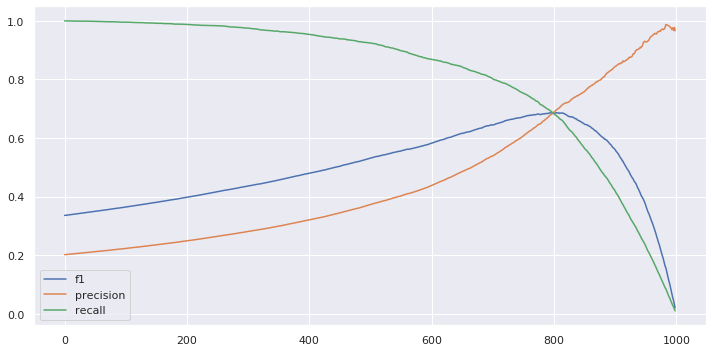

max_f1 [0.804]: 0.6864768683274021


In [16]:
f1, precision, recall = [], [], []
max_f1_threshold = -1
max_f1 = -1
for i in tqdm(range(1000)):
    _i = i / 1000.0
    
    y_pred = np.where(train_preds["preds"] > _i, 1, 0)
    
    _precision = precision_score(train_preds[TARGET], y_pred)
    if _precision == 1.0:
        break
    _f1 = f1_score(train_preds[TARGET], y_pred)
    if _f1 > max_f1:
        max_f1 = _f1
        max_f1_threshold = _i
    
    f1.append(_f1)
    precision.append(_precision)
    recall.append(recall_score(train_preds[TARGET], y_pred))
    
plt.figure(figsize=[10, 5])
plt.plot(range(len(f1)), f1, label="f1")
plt.plot(range(len(f1)), precision, label="precision")
plt.plot(range(len(f1)), recall, label="recall")
plt.legend()
plt.tight_layout()
plt.show()

print(f"max_f1 [{max_f1_threshold}]: {max_f1}")

## Feature importance

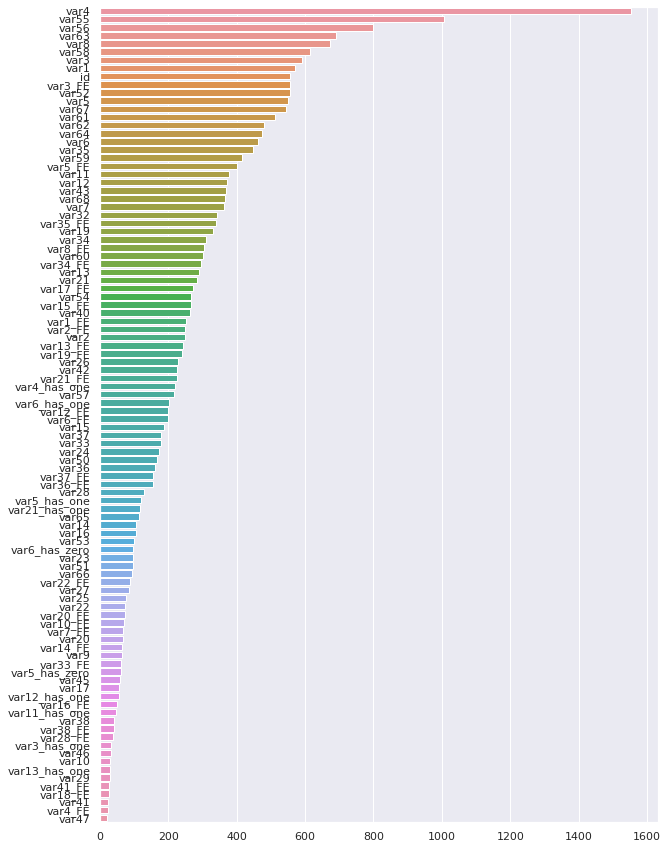

In [17]:
importances_sorted = importances.mean(axis=1).sort_values(ascending=False).head(100)
plt.figure(figsize=(10,15))
sns.barplot(y=importances_sorted.index, x=importances_sorted, orient="h")

## Clip and save sub

In [18]:
print(f"VERSION ::: {VERSION}")

VERSION ::: lgbm-v5


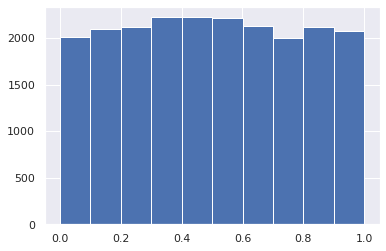

In [19]:
df_sub[TARGET].hist()

In [20]:
df_sub["predicted"] = np.where(df_sub[TARGET] > max_f1_threshold, 1, 0)
df_sub.head()

,id,predicted,y
0,0,1,0.963943
1,2,1,0.861672
2,4,0,0.729840
3,7,1,0.827324
4,15,1,0.804447


In [21]:
df_sub[["predicted", "y"]].describe()

,predicted,y
count,21183.000000,21183.000000
mean,0.194543,0.500024
std,0.395858,0.285034
min,0.000000,0.000359
25%,0.000000,0.257253
50%,0.000000,0.497286
75%,0.000000,0.743601
max,1.000000,0.999991


In [22]:
train_preds.columns = ["predicted", "y"]
train_preds["predicted"] = np.where(train_preds["y"] > max_f1_threshold, 1, 0)
train_preds.head()

,predicted,y
0,1,0.968484
1,0,0.435398
2,0,0.731586
3,0,0.497345
4,1,0.963894


In [23]:
train_preds["id"] = df_train["id"]
train_preds = train_preds[["id", "predicted", "y"]]
train_preds.head()

,id,predicted,y
0,1,1,0.968484
1,8,0,0.435398
2,30,0,0.731586
3,43,0,0.497345
4,46,1,0.963894


In [26]:
train_preds.to_csv(f"../output/mario/train_preds_{VERSION}.csv", index=False)
df_sub.to_csv(f"../output/mario/test_preds_{VERSION}.csv", index=False)
df_sub.drop("y", axis=1).to_csv(f"../output/mario/sub_{VERSION}.csv", index=False)

# Confusion Matix

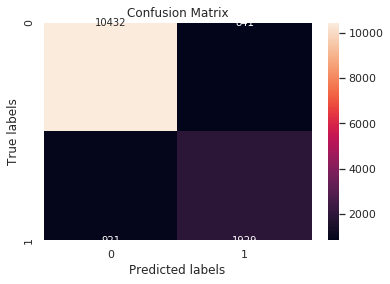

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=df_train[TARGET], y_pred=np.where(train_preds[TARGET] > max_f1_threshold, 1, 0), labels=[0, 1])

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", ax=ax);  #annot=True to annotate cells, ftm="g" to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels");
ax.set_ylabel("True labels"); 
ax.set_title("Confusion Matrix");

In [25]:
cm

array([[10432,   841],
       [  921,  1929]])